In [1]:
import json
import time
import pandas as pd
from os.path import expanduser
import sys
import os
import numpy as np
import glob

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

import yaml


!{sys.executable} -m pip install --user transcriptic
!{sys.executable} -m pip install --user autoprotocol


import transcriptic 
from transcriptic import commands, Container
from transcriptic.jupyter import objects



You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/jupyter/tacc-work/jupyter_packages/lib/python3.6/site-packages/transcriptic/config.py:29: UserWarning: `python-magic` is recommended. You may be missing some system-level dependencies if you have already pip-installed it.
Please refer to https://github.com/ahupp/python-magic#installation for more installation instructions.
  "`python-magic` is recommended. You may be missing some system-level "


In [2]:
## Get a connection to the TX API
## transcriptic_config.yml should be of the form:
##
## transcriptic:
##    email: me@my_domain.com
##    token: my_transcriptic_token
##    user_id: my_transcriptic.com
##
## transcriptic_config.yml can live wherever you want, and this
## cell will print you your current path.  You may need to set
## the path to your transcriptic_config.yml appropriately.

print(os.getcwd())
with open("../../transcriptic_config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

tx_cfg = cfg['transcriptic']
transcriptic_api = transcriptic.Connection(analytics=True, 
                                           api_root="https://secure.transcriptic.com", 
                                           email=tx_cfg['email'],
                                           feature_groups=[],
                                           organization_id='sd2org',
                                           token=tx_cfg['token'],
                                           user_id=tx_cfg['user_id']
                                          )

/home/jupyter/tacc-work/sd2nb/pysd2cat/notebooks


In [3]:
## Install pysd2cat in develop mode (allows tweaking of plots, etc.)
## This cell assumes you have used git clone to get pysd2cat in the path
## below.

os.chdir(os.path.join(expanduser('~'),'tacc-work/sd2nb/pysd2cat'))
!{sys.executable} setup.py develop --user --uninstall
!{sys.executable} setup.py develop --user 
os.chdir(os.pardir)

running develop
Removing /home/jupyter/tacc-work/jupyter_packages/lib/python3.6/site-packages/pysd2cat.egg-link (link to src)
Removing pysd2cat 0.1 from easy-install.pth file
running develop
running egg_info
writing src/pysd2cat.egg-info/PKG-INFO
writing dependency_links to src/pysd2cat.egg-info/dependency_links.txt
writing requirements to src/pysd2cat.egg-info/requires.txt
writing top-level names to src/pysd2cat.egg-info/top_level.txt
reading manifest file 'src/pysd2cat.egg-info/SOURCES.txt'
writing manifest file 'src/pysd2cat.egg-info/SOURCES.txt'
running build_ext
Creating /home/jupyter/tacc-work/jupyter_packages/lib/python3.6/site-packages/pysd2cat.egg-link (link to src)
Adding pysd2cat 0.1 to easy-install.pth file

Installed /home/jupyter/tacc-work/sd2nb/pysd2cat/src
Processing dependencies for pysd2cat==0.1
Searching for FlowCytometryTools==0.5.0
Best match: FlowCytometryTools 0.5.0
Adding FlowCytometryTools 0.5.0 to easy-install.pth file

Using /home/jupyter/tacc-work/jupyter_pa

In [ ]:
## Install non-Develop mode (use this instead of the previous cell if you want)

#!{sys.executable} -m pip uninstall -y pysd2cat 
#!{sys.executable} -m pip install git+https://gitlab.sd2e.org/dbryce/pysd2cat --user 

In [4]:
## Get all the pysd2cat functions and setup autoreload

from pysd2cat import data
from pysd2cat.data import pipeline 
from pysd2cat.data import pipeline_od
from pysd2cat.data import tx_od
from pysd2cat.analysis import threshold as thold
from pysd2cat.analysis import live_dead_classifier as ldc
from pysd2cat.analysis import live_dead_analysis as lda
from pysd2cat.plot import plot
from pysd2cat.analysis.Names import Names
from pysd2cat.analysis import calibrated_od_analysis as coa
from pysd2cat.plot import od_plot
from pysd2cat.xplan import experiment_request

%reload_ext autoreload
%autoreload 2


/home/jupyter/tacc-work/sd2nb/pysd2cat/src/pysd2cat/analysis/live_dead_analysis.py:7: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [5]:
## Add new project URIs here and run to get runs from each project

projects = [
    'https://secure.transcriptic.com/sd2org/p1c5ybxxpx2br',
    'https://secure.transcriptic.com/sd2org/p1c84yb3efaz8',
    'https://secure.transcriptic.com/sd2org/p1c8xyxs23u88',
    'https://secure.transcriptic.com/sd2org/p1c9tpxahtf89',
    'https://secure.transcriptic.com/sd2org/p1cbaqfx3u9cr',
    'https://secure.transcriptic.com/sd2org/p1cbv3n7c84g2',
    'https://secure.transcriptic.com/sd2org/p1ccm3hm9xdkf',
    'https://secure.transcriptic.com/sd2org/p1cdcfa9r2yp6',
    'https://secure.transcriptic.com/sd2org/p1ce4cse5yqhn',
    'https://secure.transcriptic.com/sd2org/p1ceybqeyr5vq',
    'https://secure.transcriptic.com/sd2org/p1cfm4nkhuzvs',
    'https://secure.transcriptic.com/sd2org/p1cgfkta6tz4j',
    'https://secure.transcriptic.com/sd2org/p1ch4snq7qg97',
    'https://secure.transcriptic.com/sd2org/p1cwvy786rgjth',
#    'https://secure.transcriptic.com/sd2org/p1cxvwcreu2gtz',
#    'https://secure.transcriptic.com/sd2org/p1cxvwewtt6euh',
#    'https://secure.transcriptic.com/sd2org/p1cxvwfwgwj2pr'
    
]


project_runs_file = os.path.join(expanduser("~"), 'sd2e-projects/sd2e-project-14/xplan-reactor/data/transcriptic/project_runs.json' )
experiment_runs = tx_od.get_run_groups(projects, project_runs_file)
#experiment_runs

In [6]:
## Get Dataframe with all calibrated OD data for all 
## experiments in experiment_runs
overwrite = False
out_dir = os.path.join(expanduser("~"), 'sd2e-projects/sd2e-project-14/xplan-reactor/data/transcriptic/od_corrected')
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

df = pd.DataFrame()
for i, experiment in experiment_runs.iterrows():
    #df = tx_od.get_meta(experiment)
    meta_and_data_df = tx_od.get_data_and_metadata_df(experiment, out_dir, overwrite=overwrite)
    meta_and_data_df['part_1_id'] = experiment['part_1_id']
    meta_and_data_df['part_2_id'] = experiment['part_2_id']
    meta_and_data_df['calibration_id'] = experiment['calibration_id']
    df = df.append(meta_and_data_df, ignore_index = True)
    #break
df.to_csv('tx_od.csv') 
df1 = df
#df

In [9]:
df=df1
#df=df.loc[(df['strain_circuit'] == 'NOR') & (df['input'] == '11')]

def get_row(s):
    head = s.rstrip('0123456789')
    return head
def get_col(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return tail


p = pd.DataFrame()
p.loc[:,'row'] = df['well'].apply(get_row)
p.loc[:,'col'] = df['well'].apply(get_col).astype(int)
p.loc[:, 'od'] = df['post_od_raw']


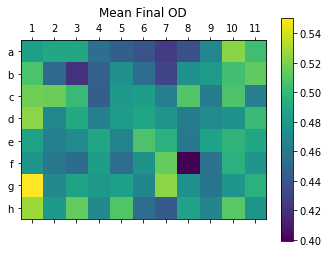

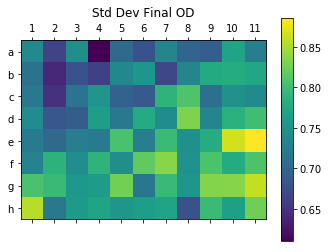

In [10]:
import matplotlib.pyplot as plt


%matplotlib inline

xtics = p.col.unique()
xtics.sort()
ytics = p.row.unique()
ytics.sort()

#print(xtics)
#print(ytics)
dat = p.groupby(['row', 'col'])['od'].agg([np.mean, np.std])
dat = dat.reset_index()
g = dat.groupby(['row'])

#print(dat)

matrix_m = []
matrix_s = []
for i, col in g:
#    print(col)
    r = col.sort_values(by='col')['mean'].values
    matrix_m.append(r)
    r = col.sort_values(by='col')['std'].values
    matrix_s.append(r)


    
#print(matrix)
#    print(row)
#rows.first()
e = plt.matshow(matrix_s)
plt.title("Mean Final OD", pad=15)
plt.colorbar(e)
plt.gca().set_xticklabels(xtics)
plt.gca().set_yticklabels(ytics)
plt.gca().set_yticks(range(0, len(ytics)))
plt.gca().set_xticks(range(0, len(xtics)))

e = plt.matshow(matrix_m)
plt.title("Std Dev Final OD", pad=15)
plt.colorbar(e)
plt.gca().set_xticklabels(xtics)
plt.gca().set_yticklabels(ytics)
plt.gca().set_yticks(range(0, len(ytics)))
plt.gca().set_xticks(range(0, len(xtics)))






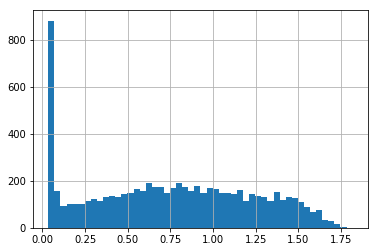

In [12]:
df['post_od_raw'].hist(bins=50)

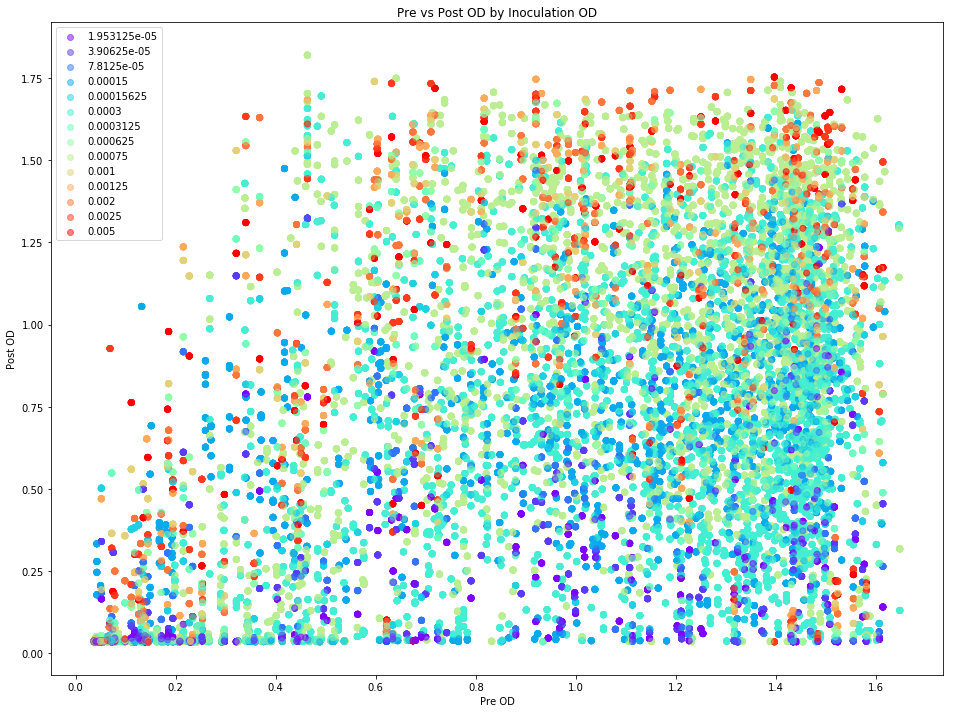

In [15]:
## Get plot of pre vs post OD with series for each inoculation OD

od_plot.get_pre_post_od_by_target_od(df, pre='pre_od_raw', post='post_od_raw', color='od')

In [16]:
od_plot.get_strain_inoculation_to_final_od(df, post='post_od_raw', color='strain')

ValueError: Image size of 2277x1230075 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2880x2160 with 1 Axes>

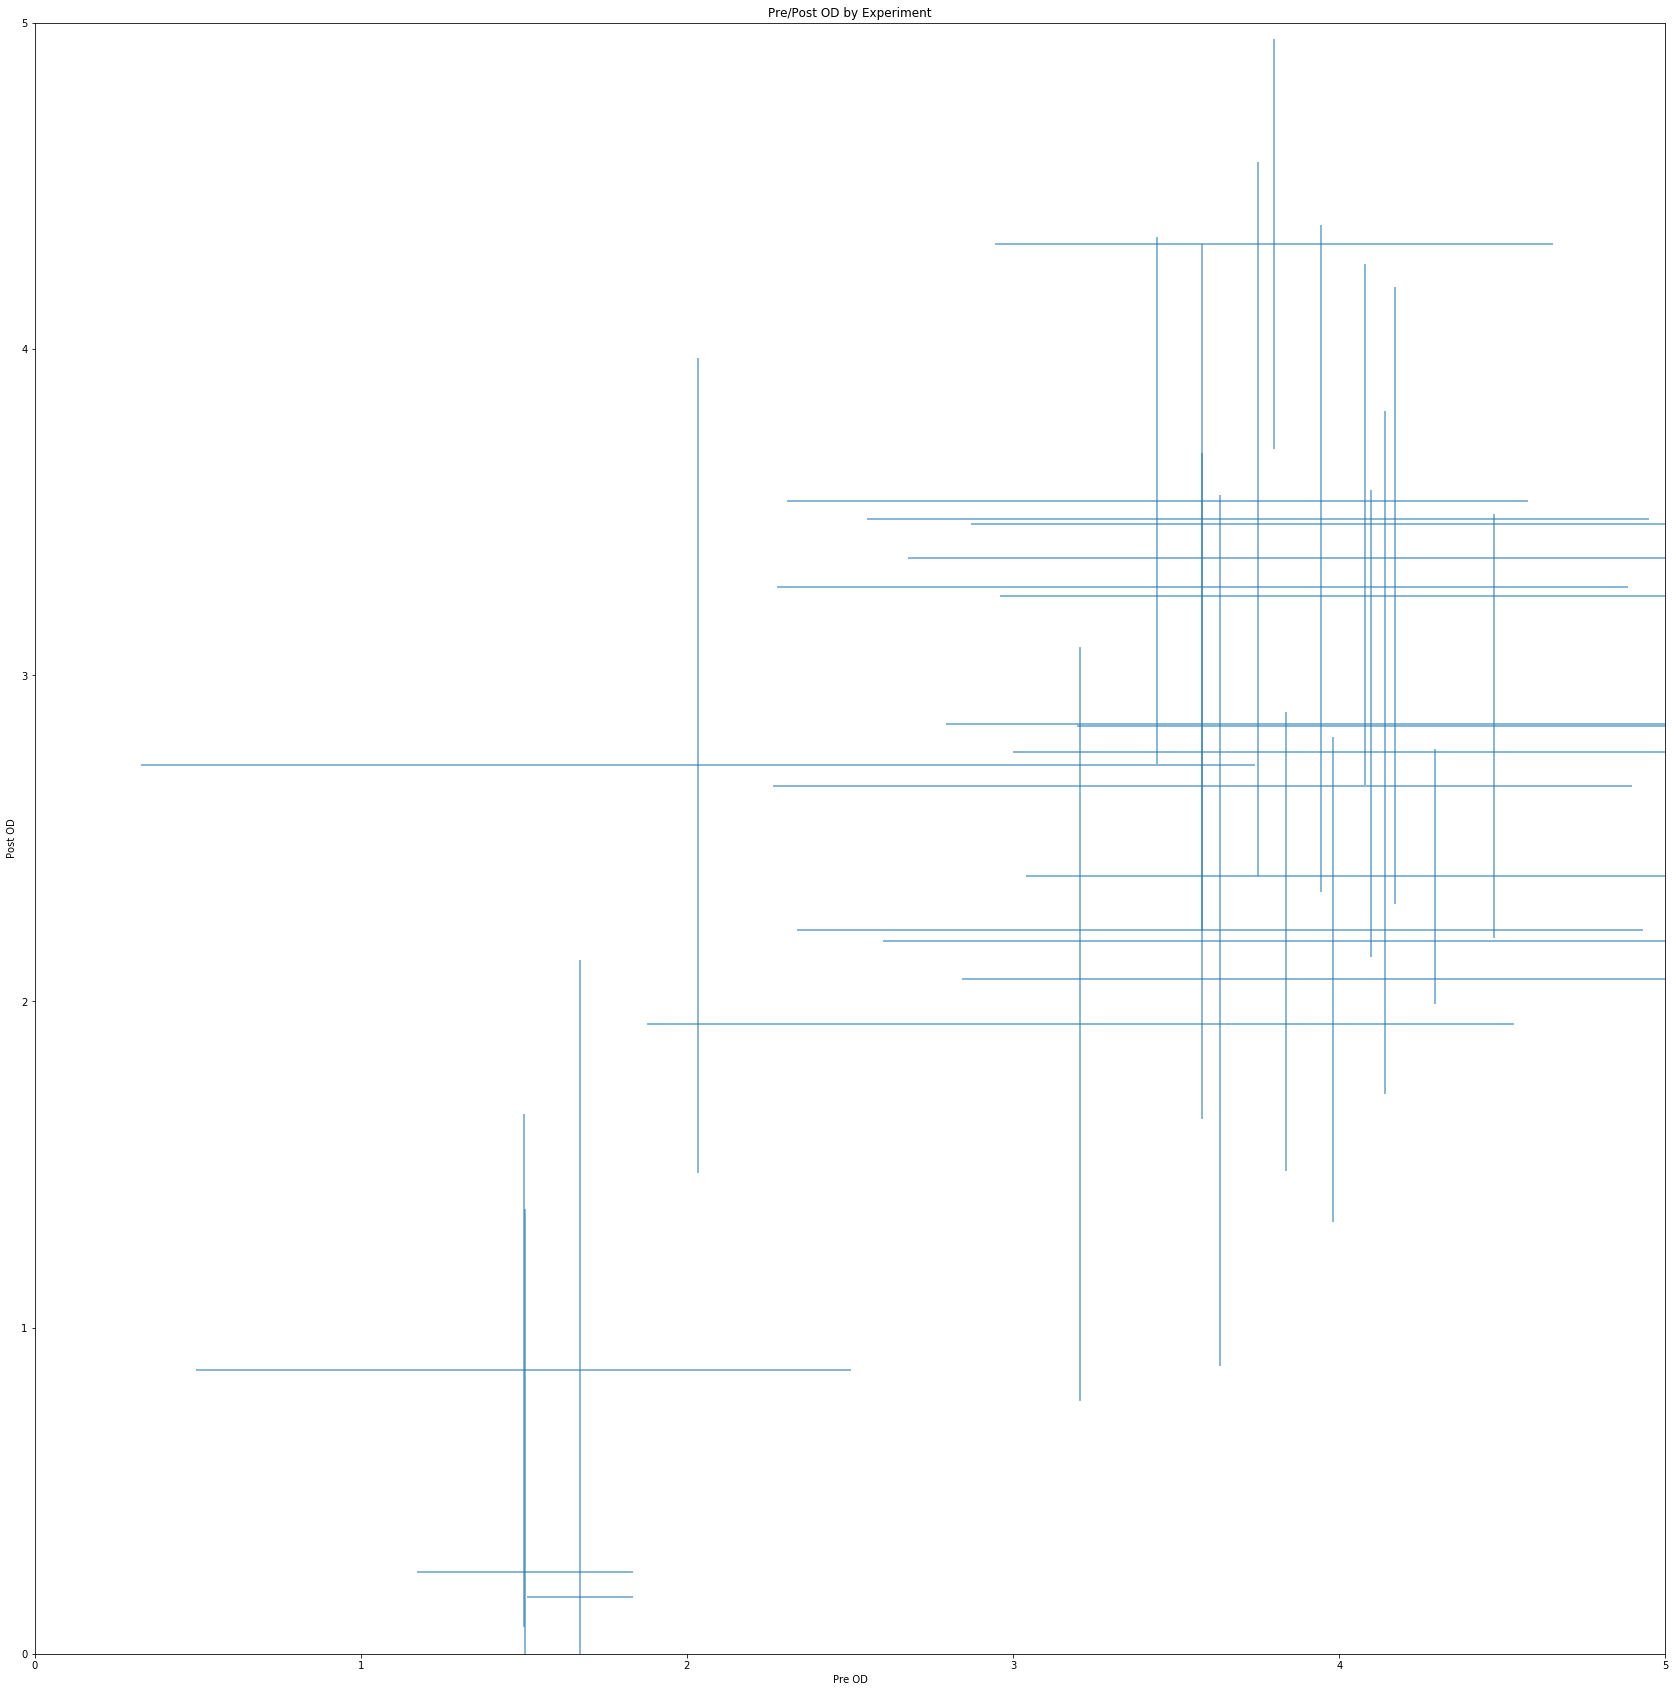

In [17]:
experiment_group_result = coa.get_per_experiment_statistics(df, pre='pre_od_corrected', post='post_od_corrected')
od_plot.get_per_experiment_od_plot(experiment_group_result, pre='pre_od_corrected', post='post_od_corrected')

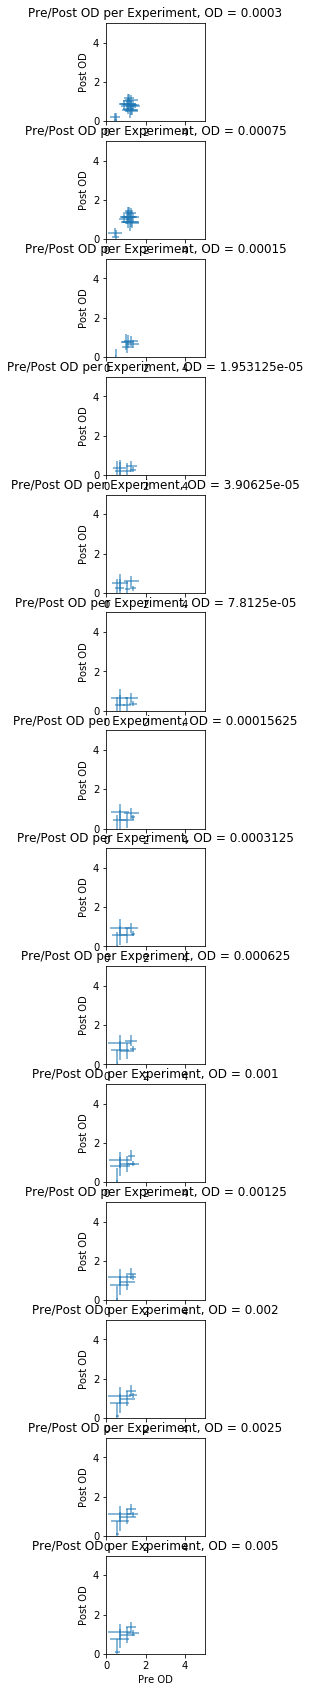

In [18]:
experiment_od_groups_result = coa.get_per_experiment_statistics_by_od(df, pre='pre_od_raw', post='post_od_raw')
plot=od_plot.get_per_experiment_od_by_od_plot(experiment_od_groups_result, pre='pre_od_raw', post='post_od_raw')

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


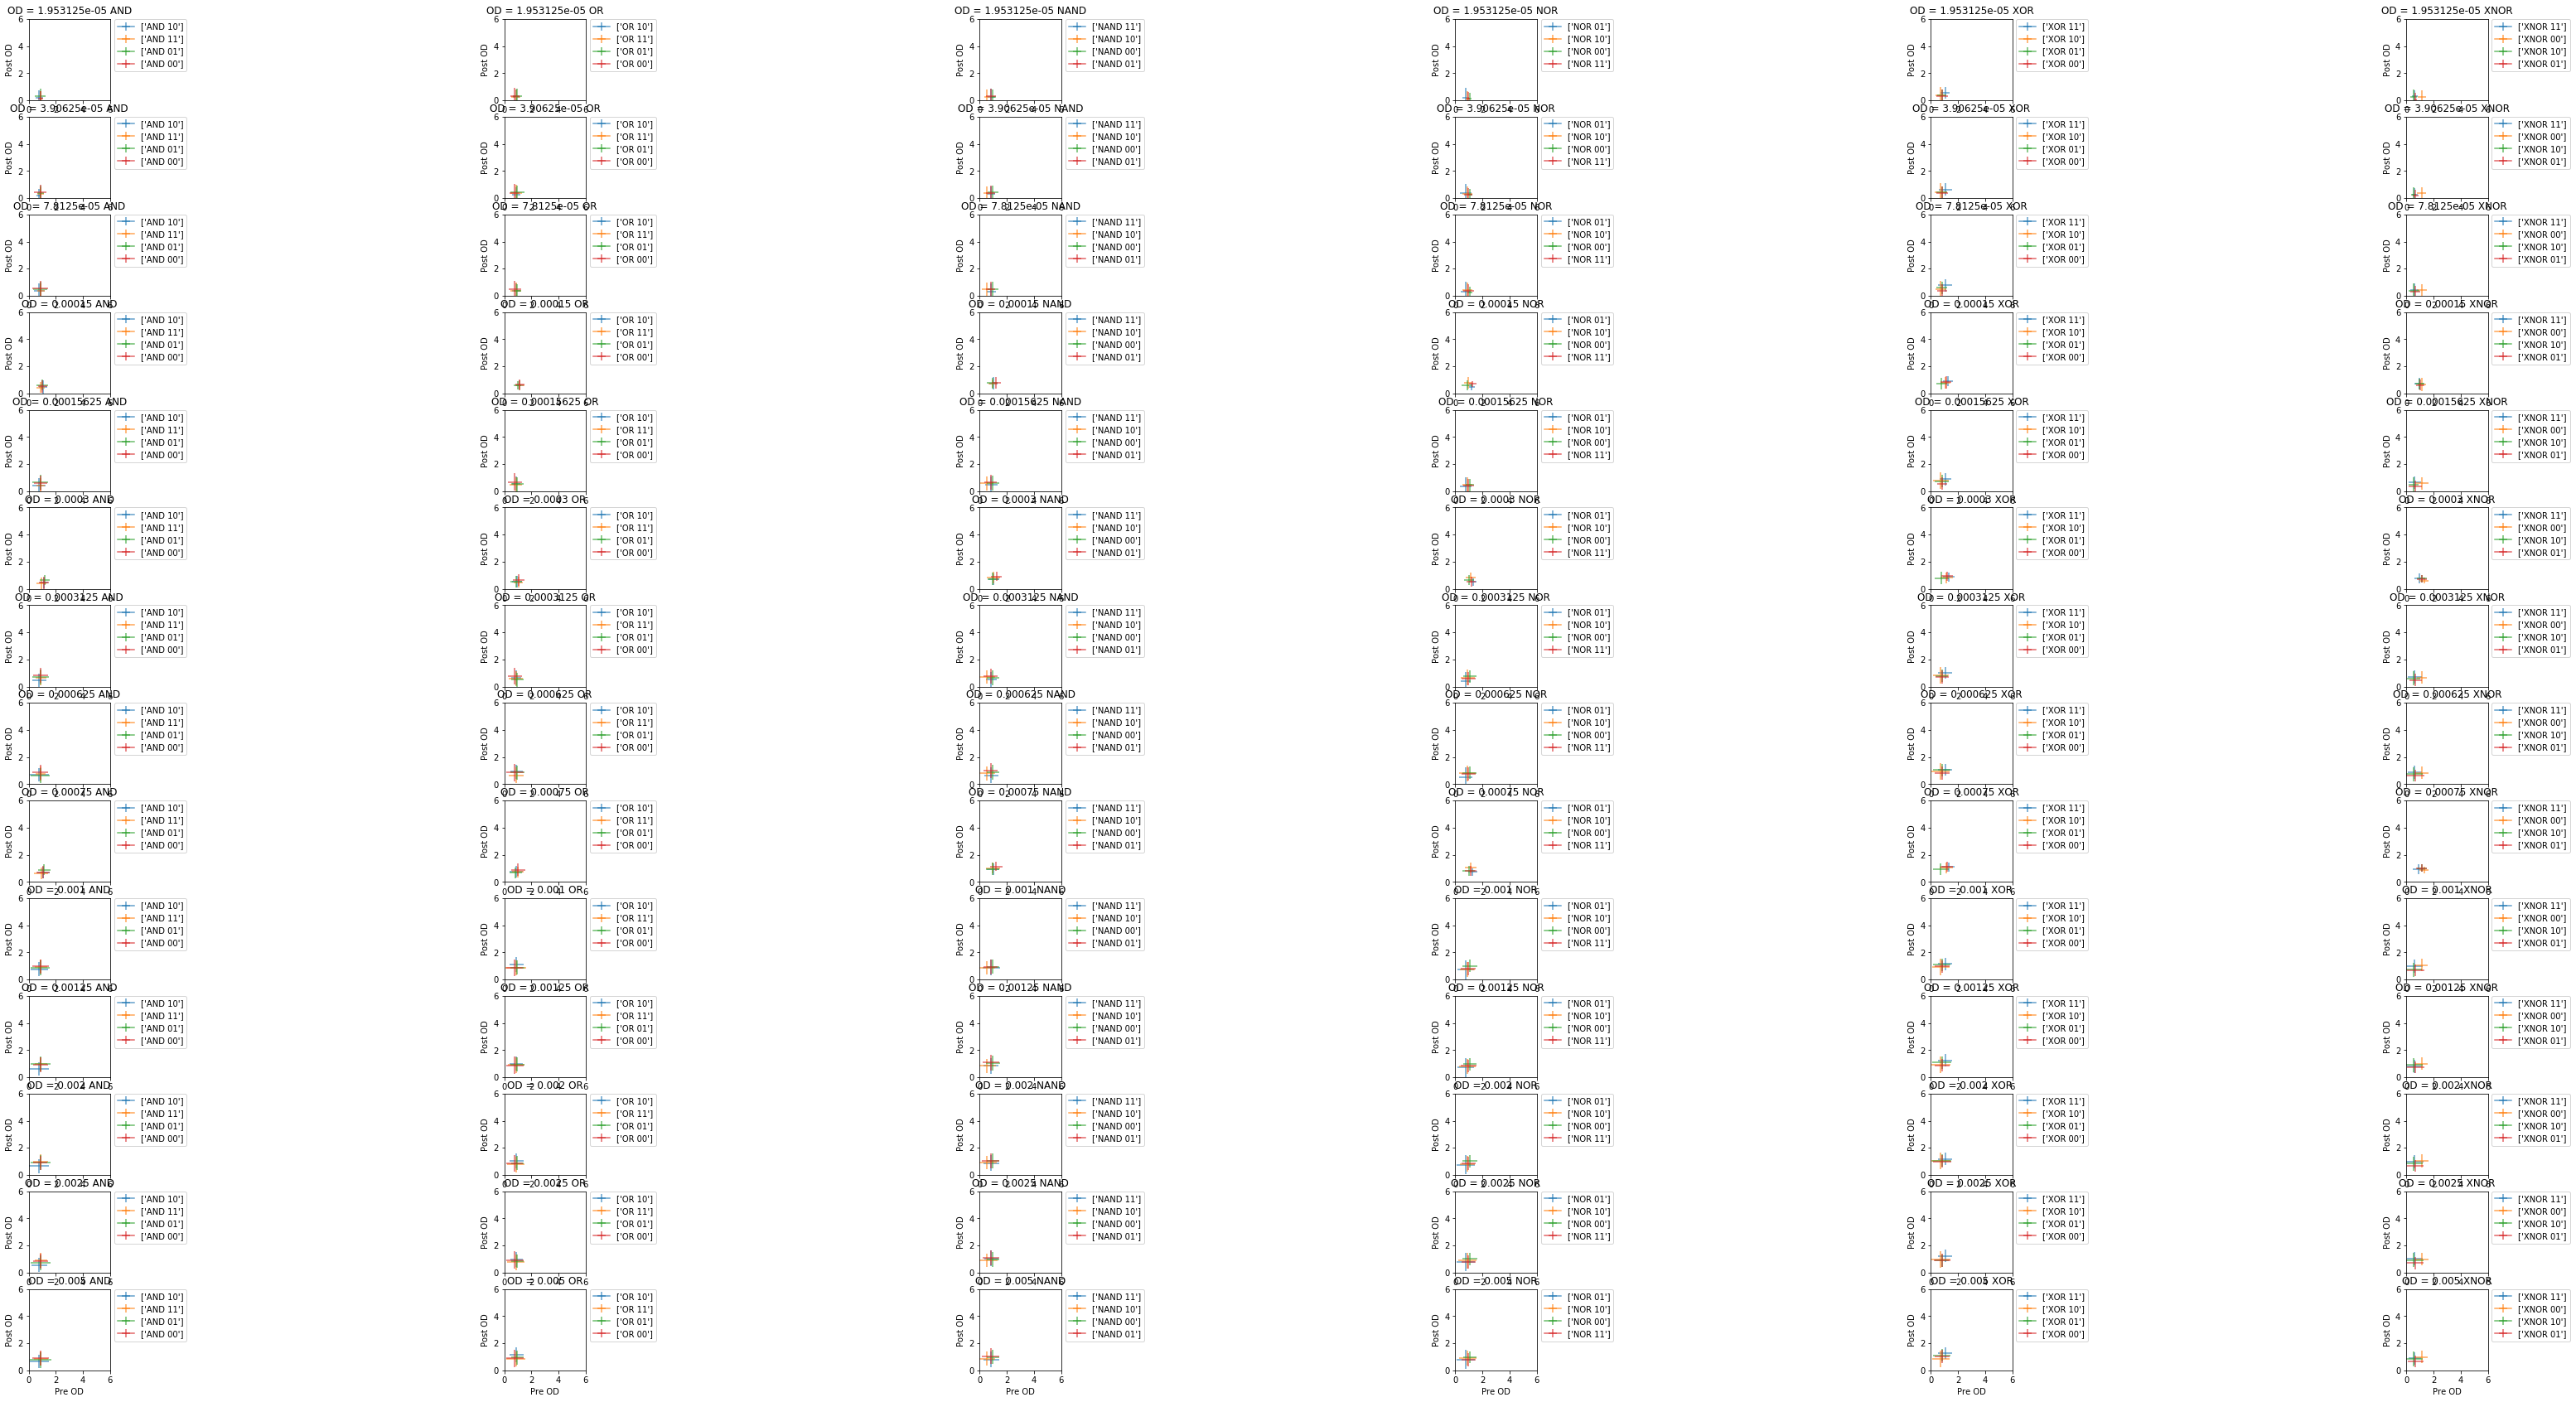

In [19]:
df.loc[:,'strain_name'] = df.apply(lambda x: x['strain_circuit'] + ' ' + x['input'], axis=1)
#result = coa.get_strain_statistics_by_od(df, pre='pre_od_raw', post='post_od_raw', group_cols=['strain', 'strain_name', 'od', 'strain_circuit'])
#plot=od_plot.get_strain_statistics_by_od_plot(result, pre='pre_od_corrected', post='post_od_corrected', label_col='strain_name')

result = coa.get_strain_statistics_by_od(df, pre='pre_od_raw', post='post_od_raw', group_cols=['strain', 'strain_name', 'od', 'strain_circuit'])
plot=od_plot.get_strain_statistics_by_od_plot(result, pre='pre_od_raw', post='post_od_raw', label_col='strain_name')

In [20]:
# Get ranked list of strain growth
#print(od_groups['od'])
od_groups = result.drop(columns=['pre_od_raw', 'strain_circuit']).groupby(['od'], sort=True)
ods = result['od'].astype(float).unique()
ods.sort()
print(ods)
sorted_strains = pd.DataFrame()
#od_groups.sort_index(ascending=True)
for od in ods:
    #i, od_group in reversed(list(od_groups)):
    print(od)
    od_group = od_groups.get_group(od)

    od_group.columns = ['_'.join(col).strip() for col in od_group.columns.values]
    od = od_group['od_'].unique()[0]
    od_group = od_group.rename(index=str, columns={"post_od_raw_mean": od})
    od_group = od_group.drop(columns=['od_', 'post_od_raw_std', 'strain_'])
    if len(sorted_strains) == 0:
        sorted_strains = od_group
    else:
        sorted_strains = sorted_strains.merge(od_group, on='strain_name_')
        #sorted_strains = sorted_strains.merge(od_group, on='strain_')
sorted_strains = sorted_strains.rename(index=str, columns={"strain_name_": "strain" })    
#sorted_strains = sorted_strains.rename(index=str, columns={"strain_": "strain" })    
sorted_strains = sorted_strains.sort_values([0.0003], ascending=False)
sorted_strains

[1.953125e-05 3.906250e-05 7.812500e-05 1.500000e-04 1.562500e-04
 3.000000e-04 3.125000e-04 6.250000e-04 7.500000e-04 1.000000e-03
 1.250000e-03 2.000000e-03 2.500000e-03 5.000000e-03]
1.953125e-05
3.90625e-05
7.8125e-05
0.00015
0.00015625
0.0003
0.0003125
0.000625
0.00075
0.001
0.00125
0.002
0.0025
0.005


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,strain,1.953125e-05,3.90625e-05,7.8125e-05,0.00015,0.00015625,0.0003,0.0003125,0.000625,0.00075,0.001,0.00125,0.002,0.0025,0.005
3,XOR 00,0.341470,0.397324,0.394099,0.821584,0.552292,0.937565,0.707656,0.817007,1.135317,0.974527,0.880386,1.006102,0.915762,1.020046
23,NAND 01,0.335608,0.353727,0.476354,0.787667,0.675671,0.904263,0.784089,0.995904,1.145055,0.930663,1.077000,1.028211,1.098869,1.050895
0,XOR 11,0.570742,0.636612,0.774993,0.904608,0.876283,0.870345,1.024023,1.062552,1.101840,1.156606,1.246969,1.190835,1.234853,1.257538
1,XOR 10,0.400947,0.460314,0.508125,0.762541,0.787197,0.834632,0.837590,0.943723,1.044779,0.938715,0.946791,1.016192,0.971851,0.848613
21,NAND 10,0.271648,0.359306,0.459461,0.717473,0.573699,0.819390,0.705900,0.798187,1.027234,0.880575,0.839022,0.906360,0.904376,0.863025
8,NOR 10,0.156850,0.323440,0.411074,0.789179,0.473874,0.814614,0.673021,0.795022,1.073673,0.745233,0.808573,0.818123,0.886115,0.901819
2,XOR 01,0.353630,0.425705,0.586151,0.748297,0.734988,0.779789,0.794700,1.050738,0.952375,1.085891,1.090092,1.055204,0.893686,1.108530
11,XNOR 11,0.296512,0.265770,0.456521,0.708387,0.629368,0.775196,0.728911,0.865145,0.941721,0.998013,0.796851,0.985436,1.038680,0.879414
17,XNOR 10,0.253481,0.253824,0.374727,0.718834,0.487429,0.764654,0.601921,0.735686,1.026125,0.732612,0.906508,0.845593,0.940815,0.835517
19,XNOR 01,0.103824,0.193345,0.287788,0.634971,0.370514,0.734735,0.491813,0.641435,1.020673,0.669881,0.734751,0.681806,0.706377,0.676526


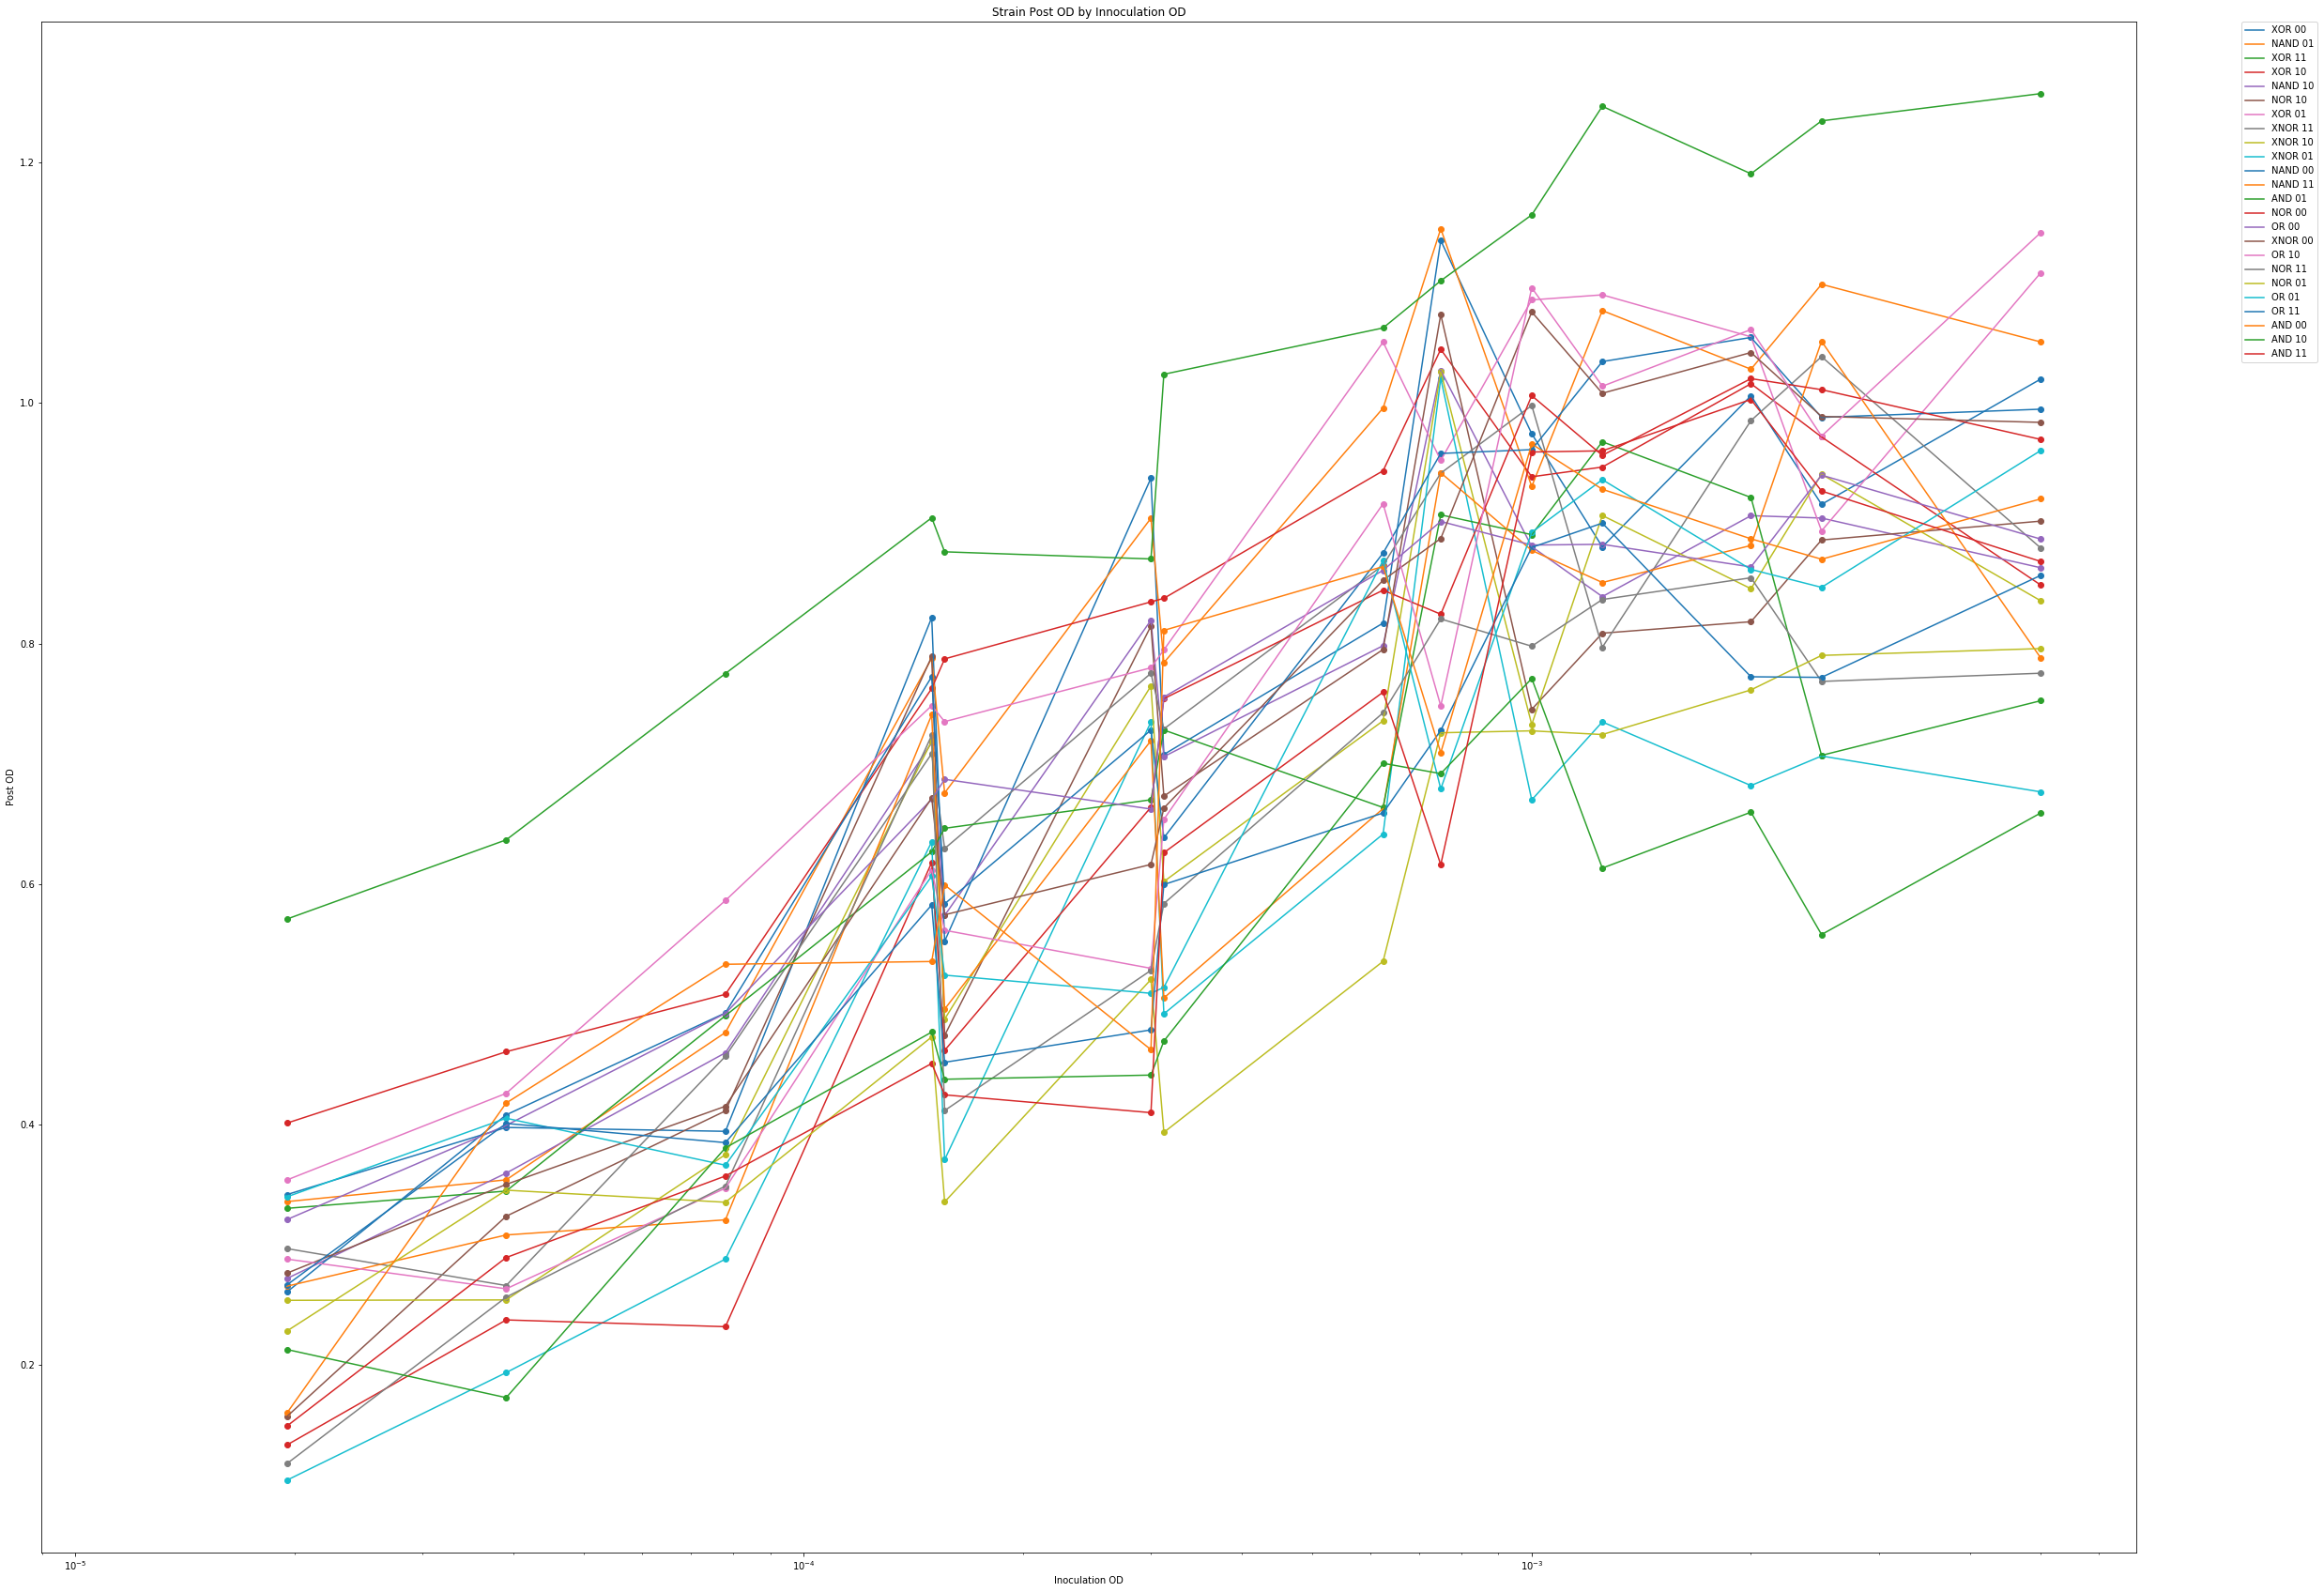

In [21]:
plot=od_plot.get_strain_growth_plot(sorted_strains.loc[sorted_strains['strain'].str.contains('')])

KeyError: 'OD600'

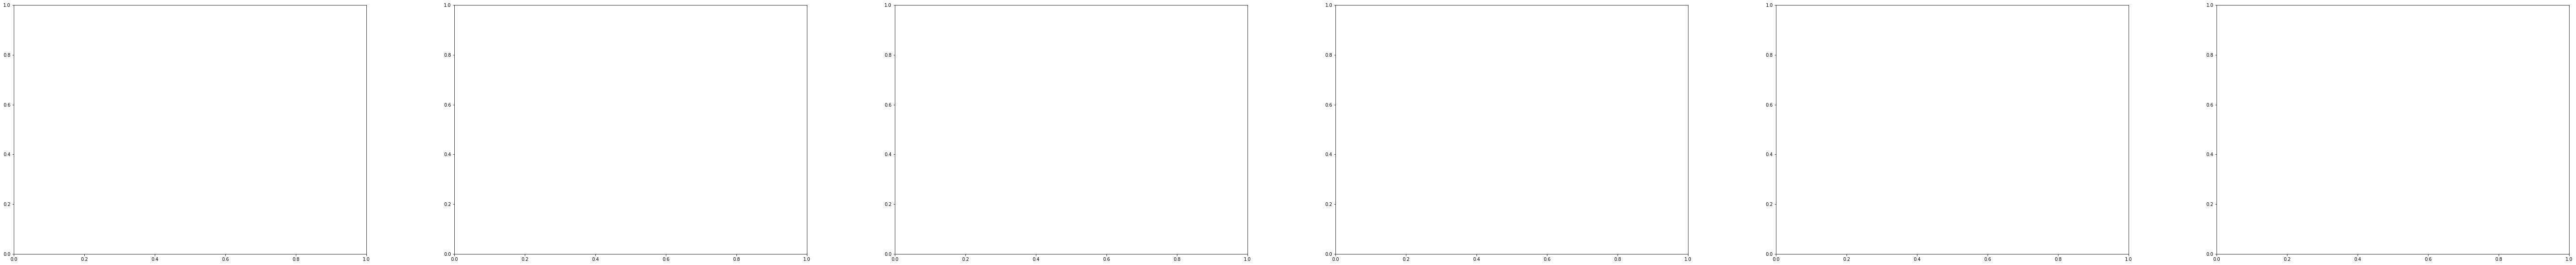

In [22]:
plot=od_plot.get_strain_by_od_plot(df, result)